## Usar isso: https://www.ncbi.nlm.nih.gov/pubmed/754827\
## Para justificar taxa de piscadas

# Neural Analysis

Esta atividade consiste em identificar e classificar sinais biológicos a partir dos dados obtidos por meio de um equipamento que realiza a medição de sinais neurais de pessoas enquanto as mesmas jogavam um jogo. Tal experimento foi realizado para compor o trabalho de mestrado de Adam, do Warthog Robotics.

Tal atividade foi realizada como segundo trabalho prático da disciplina de Inteligência Artificial ministrada pela professora Solange Rezende no 1° Semestre de 2019 na USP de São Carlos.

## Introdução Teórica

Os dados obtidos consistem em sinais neurais advindos de um capacete utilizado para eletroencefalografia que utiliza o padrão 20-10 para colocação dos sensores. Desse modo, a seguinte imagem descreve a maneira com a qual os sensores estavam distribuídos na cabeça de cada um dos utilizadores.

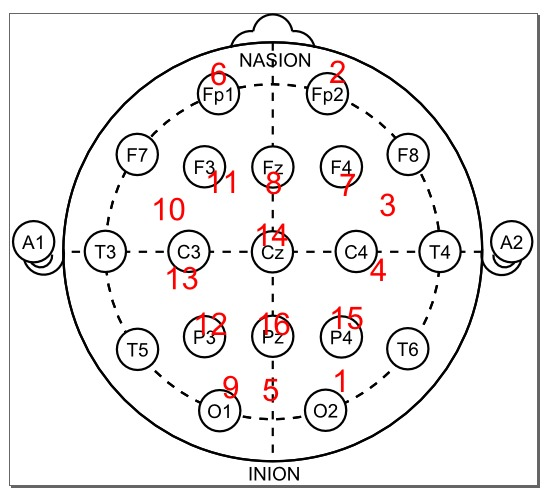

Este experimento foi realizado com 8 pessoas diferentes, cada uma delas fornece quatro bases de dados. Durante o experimento, as mesmas deveriam jogar um jogo...

O projeto consiste em:

- Identificar, de modo manual, as características que definem os sinais biológicos que queremos extrair e extrair os sinais com esses valores da nossa base.
- Clusterizar esses sinais para tentar modelar as características principais.
- Colocar esses dados em um classificador e rodar o classificador nos dados para tentar realizar a identificação automática.

Para os cabras do meu grupo, precisa fazer o seguinte:

- Filtrar piscada e olho e batida de coração.
- Jogar num K-Means e outros clusterizadores para encontrar 3 ou 4 grupos dentro dos dados que pegamos.
- Classificar e então jogar num classificador supervisionado para ele aprender.
- Rodar o classificador nos dados.
- Printar os resultados e avaliar se conseguimos ou não identificar os artefatos biológicos.

## Obtenção dos dados

Os dados estão salvos como um arquivo .csv dentro da pasta data. Eles serão importados para iniciar os trabalhos de análise dos mesmos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter("ignore", UserWarning)

Funções para cálculo de dft, idft e filtragem de dados:

In [2]:
from scipy.signal import butter, filtfilt, group_delay, firwin, freqz

def mydft(sample_frq, time_domain):

    sample_interval = 1.0/sample_frq;
    samples = len(time_domain) # length of the signal
    k = np.arange(samples) 
    frq_range = k*(sample_frq/samples) # two sides frequency range
    frq_domain = np.fft.fft(time_domain)/samples # DFT computing and normalization

    return (frq_range, frq_domain)

def myidft(frq_domain):
    samples = len(frq_domain) # length of the signal
    time_domain = np.fft.ifft(samples*frq_domain) # Denormalization and IDFT computing
    return time_domain

def myfilter(sample_frq, time_domain, pass_interval, order=5, filter_type="fir", band_stop=False):
    if(band_stop):
        ftype = "bandstop"
    else:
        if(len(pass_interval) == 1):
            ftype = "highpass"
        elif(pass_interval[0] == 0):
            ftype = "lowpass"
        else:
            ftype = "bandpass"
    
    if(ftype == "bandpass" or ftype == "bandstop"):
        norm_frq = []
        for f in pass_interval:
            norm_frq.append(f/((sample_frq/2))) # normalizing with the nyquist frequency
    elif(ftype == "lowpass"):
        norm_frq = pass_interval[1] / (sample_frq/2)
    else:
        norm_frq = pass_interval[0] / (sample_frq/2)
        
    if(filter_type=="fir"):
        b = firwin(order-1, norm_frq, pass_zero=ftype)
        a = 1
    elif(fitter_type=="butterworth"):
        b, a = butter(N=order, Wn=norm_frq, btype=ftype, analog=False)
    else:
        raise Exception("Filter type {} not recocnized.".format(filter_type))
    filtered_time_domain = filtfilt(b, a, time_domain)
    
    
    # Delay correction
    _, delay = group_delay((b, a))
    delay = int(np.round(np.mean(delay)))
    filtered_time_domain = filtered_time_domain[delay:-1]
    
    return filtered_time_domain

Função para cálculo de frequência instantânea por meio do uso da transformada de Hilbert.

In [3]:
from scipy.signal import hilbert

def getInstantaneousFrequency(sample_frq, time_domain):
    analytic_signal = hilbert(time_domain) # use the hilbert transform
    phase = np.angle(analytic_signal) # calculate the phase of the analytic signal
    phase = np.unwrap(phase) # unwrap the phase
    frequency = np.diff(phase) # differentiantion of the phase to get the frequency
    frequency = abs(frequency/((2.0*np.pi)*sample_frq)) # denormalization of the frequency
    return frequency


In [4]:
from copy import deepcopy

def normalize(data):
    ndata = deepcopy(data)
    for key in ndata:
        minv = min(ndata[key])
        maxv = max(ndata[key])
        vrange = maxv-minv
        ndata[key]-=minv
        ndata[key]/=vrange
    
    return ndata

Definição de constantes que serão utilizadas pelo código

In [5]:
sample_rate = 512 # frequencia de amostragem, 512 Hz
blinking_signal_frq = [4, 7] # intervalo de frequências dos sinais de piscada de olho
filter_order = 1000 # ordem do filtro a ser utilizada
best_channels = ["Channel 2", "Channel 6"]

Leitura dos dados

In [6]:
raw_data = pd.read_csv("data/record-[2018.11.16-10.16.29].csv")
raw_data.info()
raw_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54368 entries, 0 to 54367
Data columns (total 21 columns):
Time:512Hz        54368 non-null float64
Epoch             54368 non-null int64
Channel 1         54368 non-null float64
Channel 2         54368 non-null float64
Channel 3         54368 non-null float64
Channel 4         54368 non-null float64
Channel 5         54368 non-null float64
Channel 6         54368 non-null float64
Channel 7         54368 non-null float64
Channel 8         54368 non-null float64
Channel 9         54368 non-null float64
Channel 10        54368 non-null float64
Channel 11        54368 non-null float64
Channel 12        54368 non-null float64
Channel 13        54368 non-null float64
Channel 14        54368 non-null float64
Channel 15        54368 non-null float64
Channel 16        54368 non-null float64
Event Id          34 non-null float64
Event Date        34 non-null float64
Event Duration    34 non-null float64
dtypes: float64(20), int64(1)
memory usag

,Time:512Hz,Epoch,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,...,Channel 10,Channel 11,Channel 12,Channel 13,Channel 14,Channel 15,Channel 16,Event Id,Event Date,Event Duration
0,0.000000,0,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,...,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,NaN,NaN,NaN
1,0.001953,0,9.712509e+00,9.627963e-01,9.995093e-01,9.712509e+00,9.712509e+00,3.329517e-01,1.024203e+00,1.050531e+00,...,1.359975e+01,2.871954e+00,9.712509e+00,9.712509e+00,1.295993e+00,1.373671e+00,9.712509e+00,NaN,NaN,NaN
2,0.003906,0,8.255082e+01,6.240078e+00,5.479659e+00,8.255082e+01,8.255082e+01,9.587757e-01,5.807784e+00,5.749064e+00,...,9.966038e+01,1.918641e+01,8.255082e+01,8.255082e+01,8.700532e+00,9.753357e+00,8.255082e+01,NaN,NaN,NaN
3,0.005859,0,3.220408e+02,1.860893e+01,1.280607e+01,3.220408e+02,3.220408e+02,-1.309892e+00,1.418626e+01,1.313137e+01,...,3.353348e+02,5.828425e+01,3.220408e+02,3.220408e+02,2.534720e+01,3.028059e+01,3.220408e+02,NaN,NaN,NaN
4,0.007812,0,7.760702e+02,3.310772e+01,1.680196e+01,7.760702e+02,7.760702e+02,-1.053087e+01,1.958853e+01,1.586110e+01,...,6.955557e+02,1.091119e+02,7.760702e+02,7.760702e+02,4.181824e+01,5.470015e+01,7.760702e+02,NaN,NaN,NaN
5,0.009766,0,1.304792e+03,3.798388e+01,1.468155e+01,1.304792e+03,1.304792e+03,-2.309435e+01,1.792876e+01,1.117292e+01,...,1.006323e+03,1.457051e+02,1.304792e+03,1.304792e+03,4.238638e+01,6.489718e+01,1.304792e+03,NaN,NaN,NaN
6,0.011719,0,1.614992e+03,2.914064e+01,1.181654e+01,1.614992e+03,1.614992e+03,-2.856545e+01,1.526890e+01,7.772439e+00,...,1.073737e+03,1.502217e+02,1.614992e+03,1.614992e+03,2.375708e+01,5.383020e+01,1.614992e+03,NaN,NaN,NaN
7,0.013672,0,1.471808e+03,1.763361e+01,1.181640e+01,1.471808e+03,1.471808e+03,-2.162669e+01,1.818212e+01,1.236743e+01,...,8.369688e+02,1.196093e+02,1.471808e+03,1.471808e+03,-4.904597e+00,3.089755e+01,1.471808e+03,NaN,NaN,NaN
8,0.015625,0,9.060320e+02,1.493347e+01,1.184464e+01,9.060320e+02,9.060320e+02,-8.278406e+00,2.394179e+01,1.952693e+01,...,4.129697e+02,6.896184e+01,9.060320e+02,9.060320e+02,-3.261229e+01,9.888023e+00,9.060320e+02,NaN,NaN,NaN
9,0.017578,0,2.263633e+02,1.968124e+01,1.097778e+01,2.263633e+02,2.263633e+02,3.060367e-01,2.703347e+01,2.193512e+01,...,2.606730e+01,3.123114e+01,2.263633e+02,2.263633e+02,-4.861875e+01,-7.347121e-02,2.263633e+02,NaN,NaN,NaN


## Tratamento de dados

Como foi possível observar, existem três colunas (Event Id, Event Date e Event Duration) que possuem valores nulos para todas as entradas, além disso, conforme exposto na introdução teórica, alguns sensores podem ser desconsiderados.   
Além disso a época da medição também será desconsiderada, uma vez que pode ser extrapolada do tempo se necessário.

In [7]:
# Remocao de colunas nao utilizadas
data = raw_data.drop(["Event Id",
                      "Event Date",
                      "Event Duration",
                      "Epoch",
                      "Channel 1",
                      "Channel 4",
                      "Channel 5",
                      "Channel 9",
                      "Channel 12",
                      "Channel 13",
                      "Channel 16"], axis=1)
# Separacao da coluna de tempo
time_data = data["Time:512Hz"]
data = data.drop(["Time:512Hz"], axis=1)
data

,Channel 2,Channel 3,Channel 6,Channel 7,Channel 8,Channel 10,Channel 11,Channel 14,Channel 15
0,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10,-4.000000e-10
1,9.627963e-01,9.995093e-01,3.329517e-01,1.024203e+00,1.050531e+00,1.359975e+01,2.871954e+00,1.295993e+00,1.373671e+00
2,6.240078e+00,5.479659e+00,9.587757e-01,5.807784e+00,5.749064e+00,9.966038e+01,1.918641e+01,8.700532e+00,9.753357e+00
3,1.860893e+01,1.280607e+01,-1.309892e+00,1.418626e+01,1.313137e+01,3.353348e+02,5.828425e+01,2.534720e+01,3.028059e+01
4,3.310772e+01,1.680196e+01,-1.053087e+01,1.958853e+01,1.586110e+01,6.955557e+02,1.091119e+02,4.181824e+01,5.470015e+01
5,3.798388e+01,1.468155e+01,-2.309435e+01,1.792876e+01,1.117292e+01,1.006323e+03,1.457051e+02,4.238638e+01,6.489718e+01
6,2.914064e+01,1.181654e+01,-2.856545e+01,1.526890e+01,7.772439e+00,1.073737e+03,1.502217e+02,2.375708e+01,5.383020e+01
7,1.763361e+01,1.181640e+01,-2.162669e+01,1.818212e+01,1.236743e+01,8.369688e+02,1.196093e+02,-4.904597e+00,3.089755e+01
8,1.493347e+01,1.184464e+01,-8.278406e+00,2.394179e+01,1.952693e+01,4.129697e+02,6.896184e+01,-3.261229e+01,9.888023e+00
9,1.968124e+01,1.097778e+01,3.060367e-01,2.703347e+01,2.193512e+01,2.606730e+01,3.123114e+01,-4.861875e+01,-7.347121e-02


Além da remoção dos dados não utilizados será calculada a frequência instantânea para cada ponto em cada canal, isso será feito por meio do cálculo da transformada de Hilbert dos sinais.    
O objetivo da adição desses dados não é filtrar os sinais com a frequência instantânea, mas sim utilizar esta informação como mais uma propriedade para as etapas de classificação posteriores.

In [8]:
frequency_data = pd.DataFrame()
for key in data:
    frequency_data[key+" F"] = getInstantaneousFrequency(sample_rate, data[key])
# Remover ultimo ponto dos dados pois o calculo da frequencia instantanea usa uma derivada, causando a perda de um ponto.
data = data.drop(data.index[-1])
time_data = time_data.drop(time_data.index[-1])
frequency_data

,Channel 2 F,Channel 3 F,Channel 6 F,Channel 7 F,Channel 8 F,Channel 10 F,Channel 11 F,Channel 14 F,Channel 15 F
0,0.000018,0.000019,0.000014,0.000018,0.000020,3.117258e-09,0.000011,0.000959,0.000115
1,0.000067,0.000076,0.000021,0.000064,0.000074,1.987279e-08,0.000052,0.000097,0.000279
2,0.000097,0.000088,0.000064,0.000090,0.000098,6.831500e-08,0.000079,0.000122,0.000182
3,0.000138,0.000121,0.000142,0.000102,0.000117,9.912124e-08,0.000115,0.000207,0.000139
4,0.000132,0.000039,0.000170,0.000039,0.000005,1.191209e-07,0.000107,0.000179,0.000097
5,0.000129,0.000004,0.000183,0.000028,0.000112,2.244189e-08,0.000124,0.000203,0.000122
6,0.000039,0.000029,0.000175,0.000011,0.000010,4.785186e-08,0.000109,0.000180,0.000092
7,0.000096,0.000037,0.000164,0.000062,0.000105,1.433420e-07,0.000113,0.000171,0.000082
8,0.000063,0.000034,0.000118,0.000067,0.000094,1.311760e-07,0.000023,0.000178,0.000045
9,0.000056,0.000004,0.000006,0.000066,0.000084,5.779931e-08,0.000300,0.000162,0.000023


## Análise dos dados

Agora, será feita a análise dos dados para identificar potenciais características que possam ser úteis.

In [9]:
data.describe()

,Channel 2,Channel 3,Channel 6,Channel 7,Channel 8,Channel 10,Channel 11,Channel 14,Channel 15
count,54367.000000,54367.000000,54367.000000,54367.000000,54367.000000,5.436700e+04,54367.000000,54367.000000,5.436700e+04
mean,-0.013425,-0.009662,-0.008351,-0.003202,-0.007579,-5.268355e+02,-0.013284,-0.018763,2.346276e-01
std,21.478758,12.723961,28.086001,13.479125,12.707182,2.302059e+06,40.581813,58.452743,3.257994e+06
min,-187.835399,-76.348755,-227.950777,-81.716186,-73.165099,-1.126000e+08,-248.725058,-302.143497,-1.126364e+08
25%,-9.329950,-7.818664,-14.771419,-7.452977,-7.917517,-2.596823e+02,-27.345929,-35.478086,-4.415373e+01
50%,0.320148,0.051918,0.604087,-0.020457,-0.059577,-8.652275e+00,0.209692,-1.019647,-1.350464e+00
75%,9.725521,7.764838,15.536267,7.556581,8.068407,2.435265e+02,27.229456,33.915996,4.166715e+01
max,161.200798,88.293258,207.852728,84.469622,62.570607,3.667353e+07,269.009659,375.423734,1.126231e+08


Inicialmente os dados serão expostos no domínio do tempo, antes de qualquer filtragem.

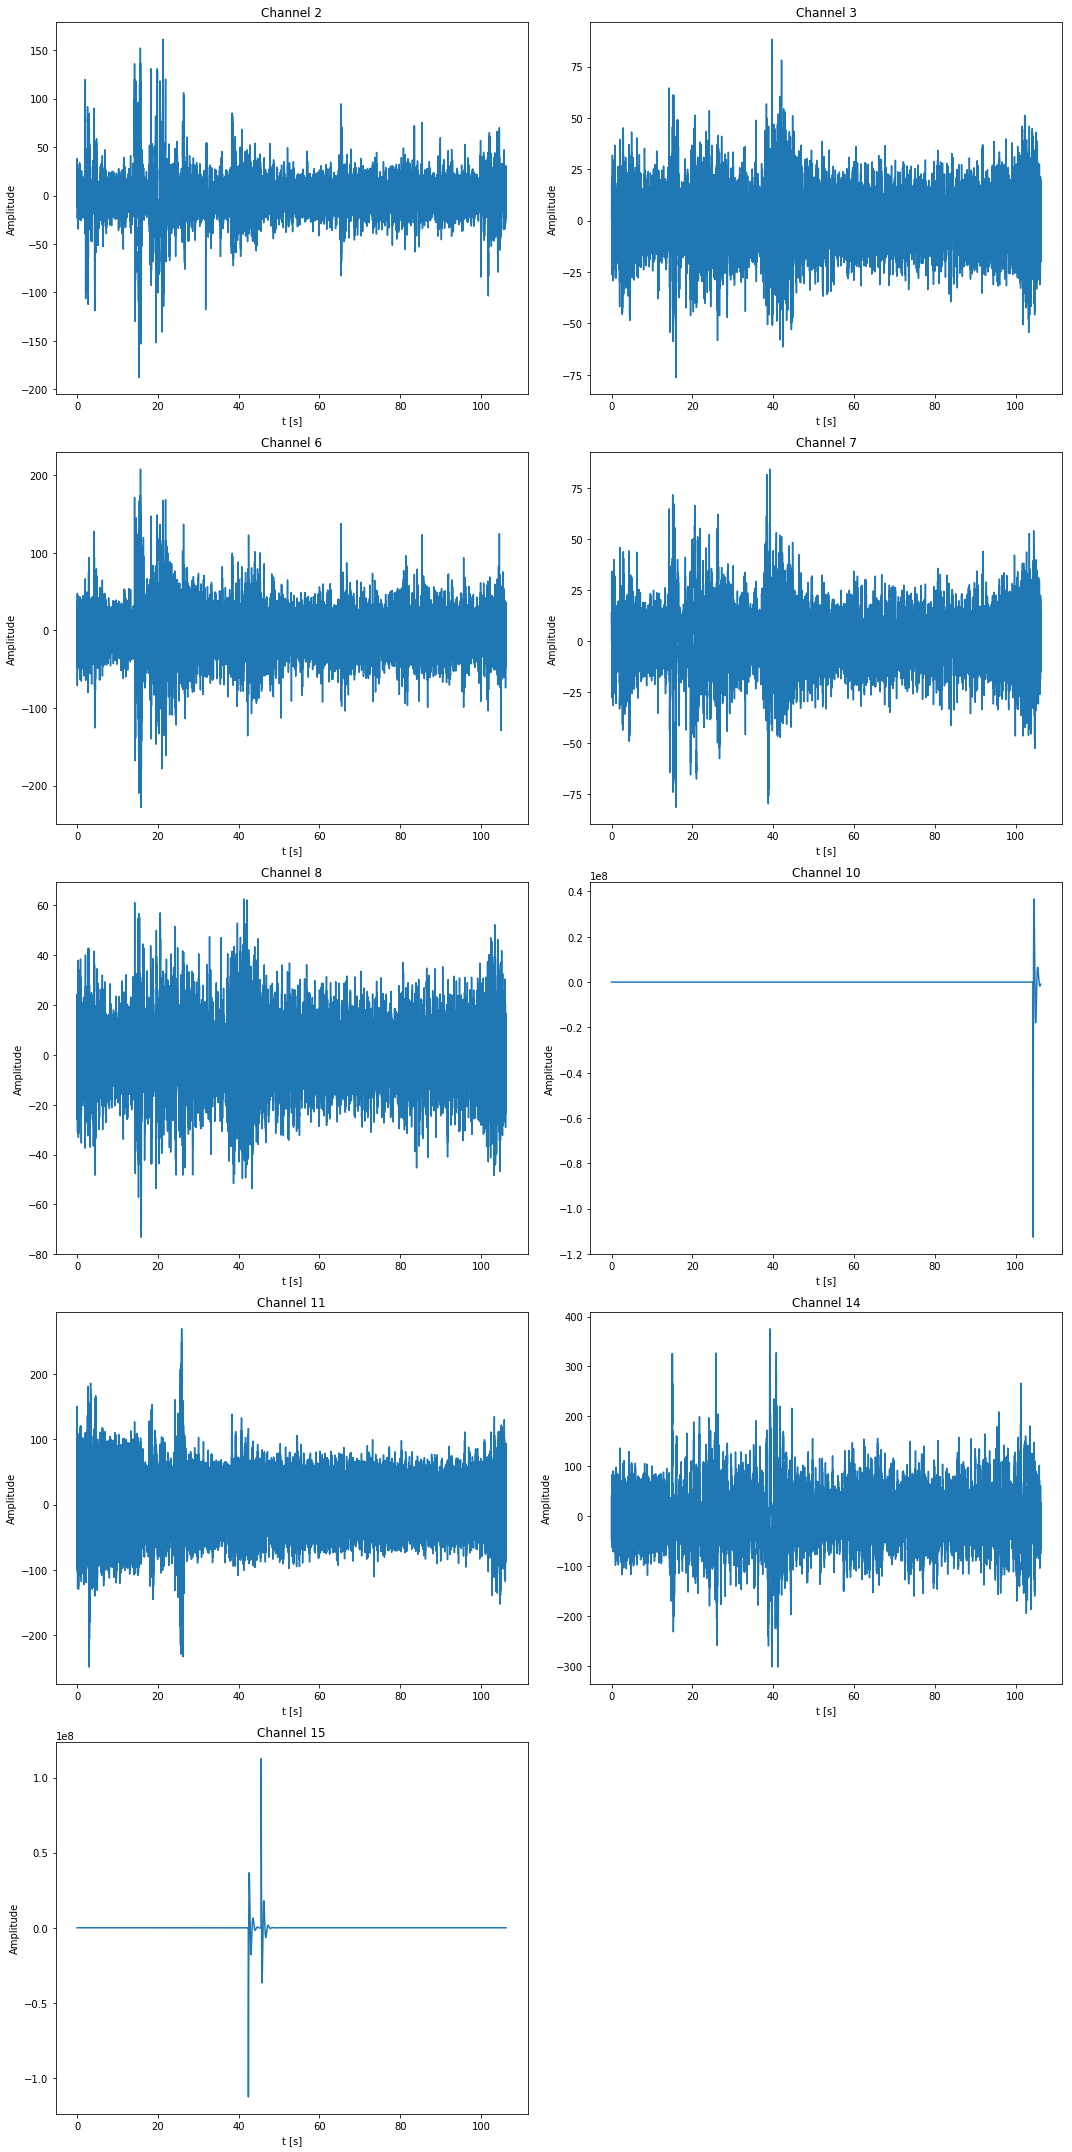

In [10]:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
line = 0
column = 0
for key in data:
    ax[line][column].plot(time_data, data[key])
    ax[line][column].set_title(key)
    ax[line][column].set_xlabel("t [s]")
    ax[line][column].set_ylabel("Amplitude")
    if(column == 1):
        line += 1
        column = 0
    else:
        column = 1
    
fig.delaxes(ax[4][1])
plt.tight_layout()


Agora será calculada a transformada discreta de Fourier de cada canal para caracterizar os canais no domínimo da frequência.

In [11]:
frq_data = pd.DataFrame()
frq_range = None # este valor sera o mesmo para todos os canais, como a taxa de amostragem e a mesma
for key in data:
    frq_range, frq_data[key] = mydft(sample_rate, data[key])
    
frq_data

,Channel 2,Channel 3,Channel 6,Channel 7,Channel 8,Channel 10,Channel 11,Channel 14,Channel 15
0,(-0.01342535252760149+0j),(-0.009662334522421509+0j),(-0.008351473522044668+0j),(-0.0032016832120110345+0j),(-0.0075791092593504306+0j),(-526.835486250618+0j),(-0.013284103550847047+0j),(-0.018763146886870294+0j),(0.23462764249447182+0j)
1,(-0.013425709104052684-4.238220588490859e-05j),(-0.00966366045208413+3.876483528341849e-06j),(-0.00835401721663531-2.9775574290591223e-05j),(-0.003208755932173257+3.1012164577603463e-06j),(-0.007579542965478938-2.9339683145315172e-06j),(-526.7738463932141+17.1009303580754j),(-0.013286882674597053-1.1904547054937857e-05j),(-0.018791765676082248+6.0080361826684466e-05j),(0.25537249653977745+0.010812699716012954j)
2,(-0.01343157748108528-9.096187013187359e-05j),(-0.009656912984638225-2.1568325807084685e-05j),(-0.008318455024762745-7.584816092103547e-05j),(-0.0031570532686637995-5.004184440701641e-05j),(-0.007579566845955231-1.3393982680095752e-05j),(-526.7213068792188+34.95231537023826j),(-0.013321273875308681-4.9276994740979014e-05j),(-0.01875600596642443+2.9702709495550013e-05j),(0.038796761736202494-0.3265971694619498j)
3,(-0.013434769896376066-0.00012077601673319947j),(-0.009731041042516358+2.3454345578560342e-05j),(-0.008449086359849199-0.00020106931140404603j),(-0.0033836679432938106-6.462567574011157e-05j),(-0.007609852234715269-2.9302365476295876e-05j),(-527.0554533734032+54.255408511440734j),(-0.013372307059367603+1.3085872907253676e-05j),(-0.01906794548249232-0.00020924954121146974j),(0.2870298016043396+1.9022123279870815j)
4,(-0.013481850693102787-0.00021712335579888208j),(-0.00960188708584862-2.36088338137984e-05j),(-0.008315766904376779+7.854263246737167e-05j),(-0.003035298783924682+0.00016210132431093892j),(-0.007611091120038252-2.745247382040074e-05j),(-528.421962889248+75.5636840197526j),(-0.01344111963184781-0.00018548738850155628j),(-0.018877614602517915+5.378812323512164e-05j),(3.020156260417855-5.2694716759850735j)
5,(-0.013591604539850661-0.00011072104537561386j),(-0.009893829441484465-1.894300613383461e-05j),(-0.008144208563924496-0.0005139554219536827j),(-0.00325638046864168-0.0005465519136145722j),(-0.007606124228354163-0.00010840823938049818j),(-531.6514892073792+99.3903745046493j),(-0.01382852042791132+7.428496787762921e-05j),(-0.01993627197031756-0.0012959252772871846j),(-11.854858690807372+7.737183867448895j)
6,(-0.013383998915901921-0.00013667563743545812j),(-0.009505729889684114+0.00016776115973705558j),(-0.008983239385039582-8.133119062221538e-05j),(-0.0037484721493734343+0.0004887271193083459j),(-0.007673715593354818-5.1909346748223776e-05j),(-537.7060944536556+125.76305168229473j),(-0.013333886744446986-0.00042514516240598735j),(-0.018186891384807682+0.0026463498958274735j),(29.453656456028707-1.614235973557683j)
7,(-0.01358158841148718-0.00045799908043537397j),(-0.009840085078976983-0.0004629121235234963j),(-0.007142443011085027-5.808820326918631e-05j),(-0.0018686569429753302-0.0002803715484207803j),(-0.007393222441586846-0.00011409720908746436j),(-548.013221273486+154.87850238950347j),(-0.01473275085671935-0.0010384338001555424j),(-0.01704339241726455-0.0032342102391311415j),(-47.42694343914635-23.576050591796665j)
8,(-0.01349116517081864+2.8748973164012783e-06j),(-0.009980598765086095+0.0005056249244456082j),(-0.009242151673005279-0.0018953771657114478j),(-0.004574528014006962-0.0012833799649012766j),(-0.00785156581018216-8.088590033467568e-06j),(-563.318919513419+186.3015672842023j),(-0.014708946365241731+0.0010724093695528875j),(-0.018643897032856842+0.002662467734223052j),(50.045564023651636+73.30620986009893j)
9,(-0.013752420181068833-0.001041771498056584j),(-0.009550227936616787-0.0005708558278775975j),(-0.009379227069704139+0.0018466836929313547j),(-0.0032172244853131047+0.002182744048693229j),(-0.007805762738378923+0.00013743169545537832j),(-585.5934522425084+219.15507772371478j),(-0.013546659055637395-0.0010189590642622364j),(-0.009934469297035701-0.002824

Uma forma mais simples de se visualizar a informação dos sinais em frequência é por meio do diagrama de Bode, contendo ganho de um sinal no domínio da frequência, isso será feito a seguir:

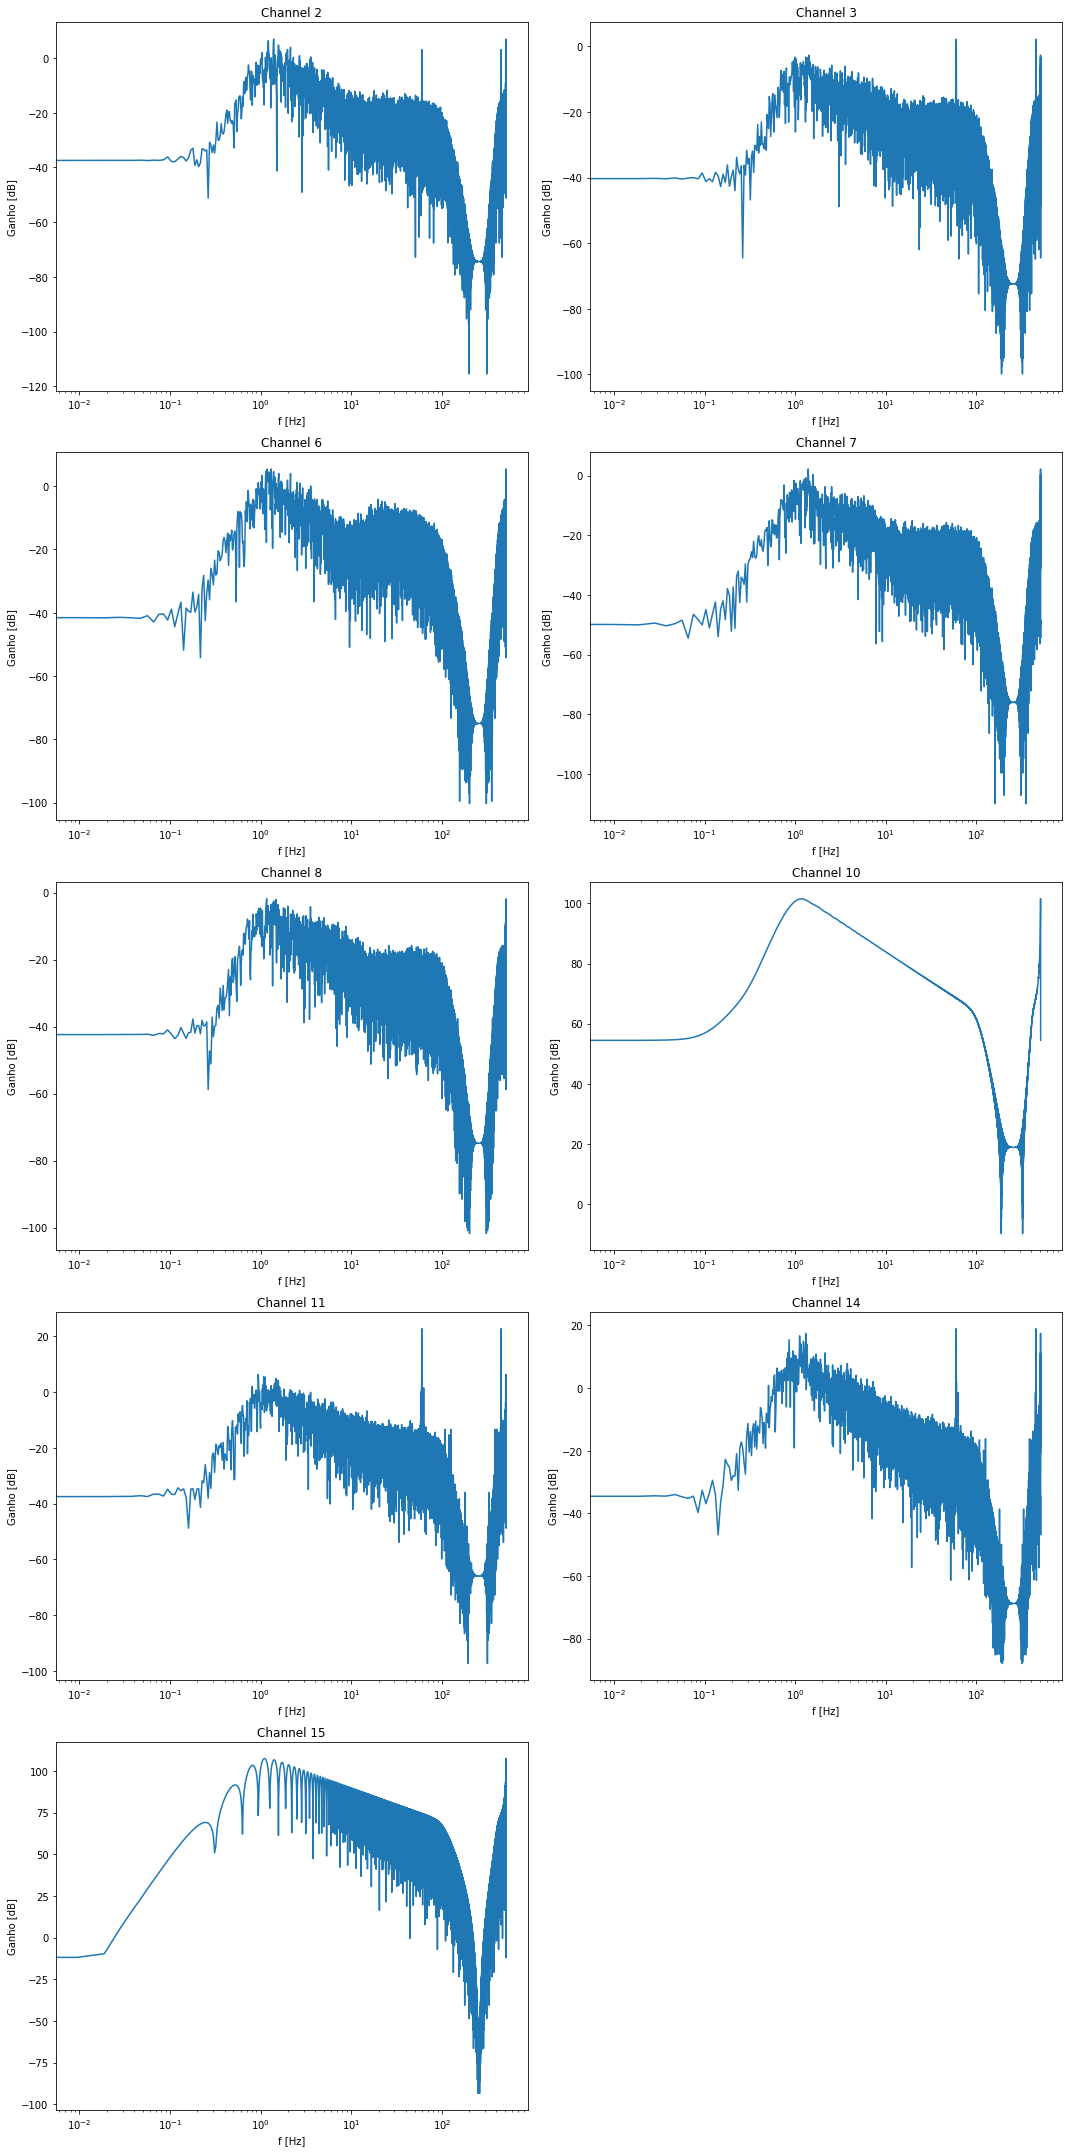

In [12]:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
line = 0
column = 0
for key in frq_data:
    ax[line][column].semilogx(frq_range, 20*(np.log(abs(frq_data[key]))/np.log(10)))
    ax[line][column].set_title(key)
    ax[line][column].set_xlabel("f [Hz]")
    ax[line][column].set_ylabel("Ganho [dB]")
    if(column == 1):
        line += 1
        column = 0
    else:
        column = 1
    
fig.delaxes(ax[4][1])
plt.tight_layout()

## Extraindo os dados com filtro
Serão extraídos os dados na faixa de frequências em que a piscada ocorre, de 4 Hz a 7 Hz.      
Isso será feito com um filtro FIR de ordem 1000.

In [13]:
# Filtragem dos dados:
filtered_data = pd.DataFrame()
for key in data:
    filtered_data[key] = myfilter(sample_rate, data[key], blinking_signal_frq, filter_order)

Como os dados passaram por um filtro, é possível que certos pontos tenham sido descartados para compensar o atraso causado pelo filtro, por isso, deve-se definir um novo eixo de tempo para os dados filtrados:

In [14]:
filtered_time_data = time_data[0:(len(filtered_data[filtered_data.keys()[0]]))]

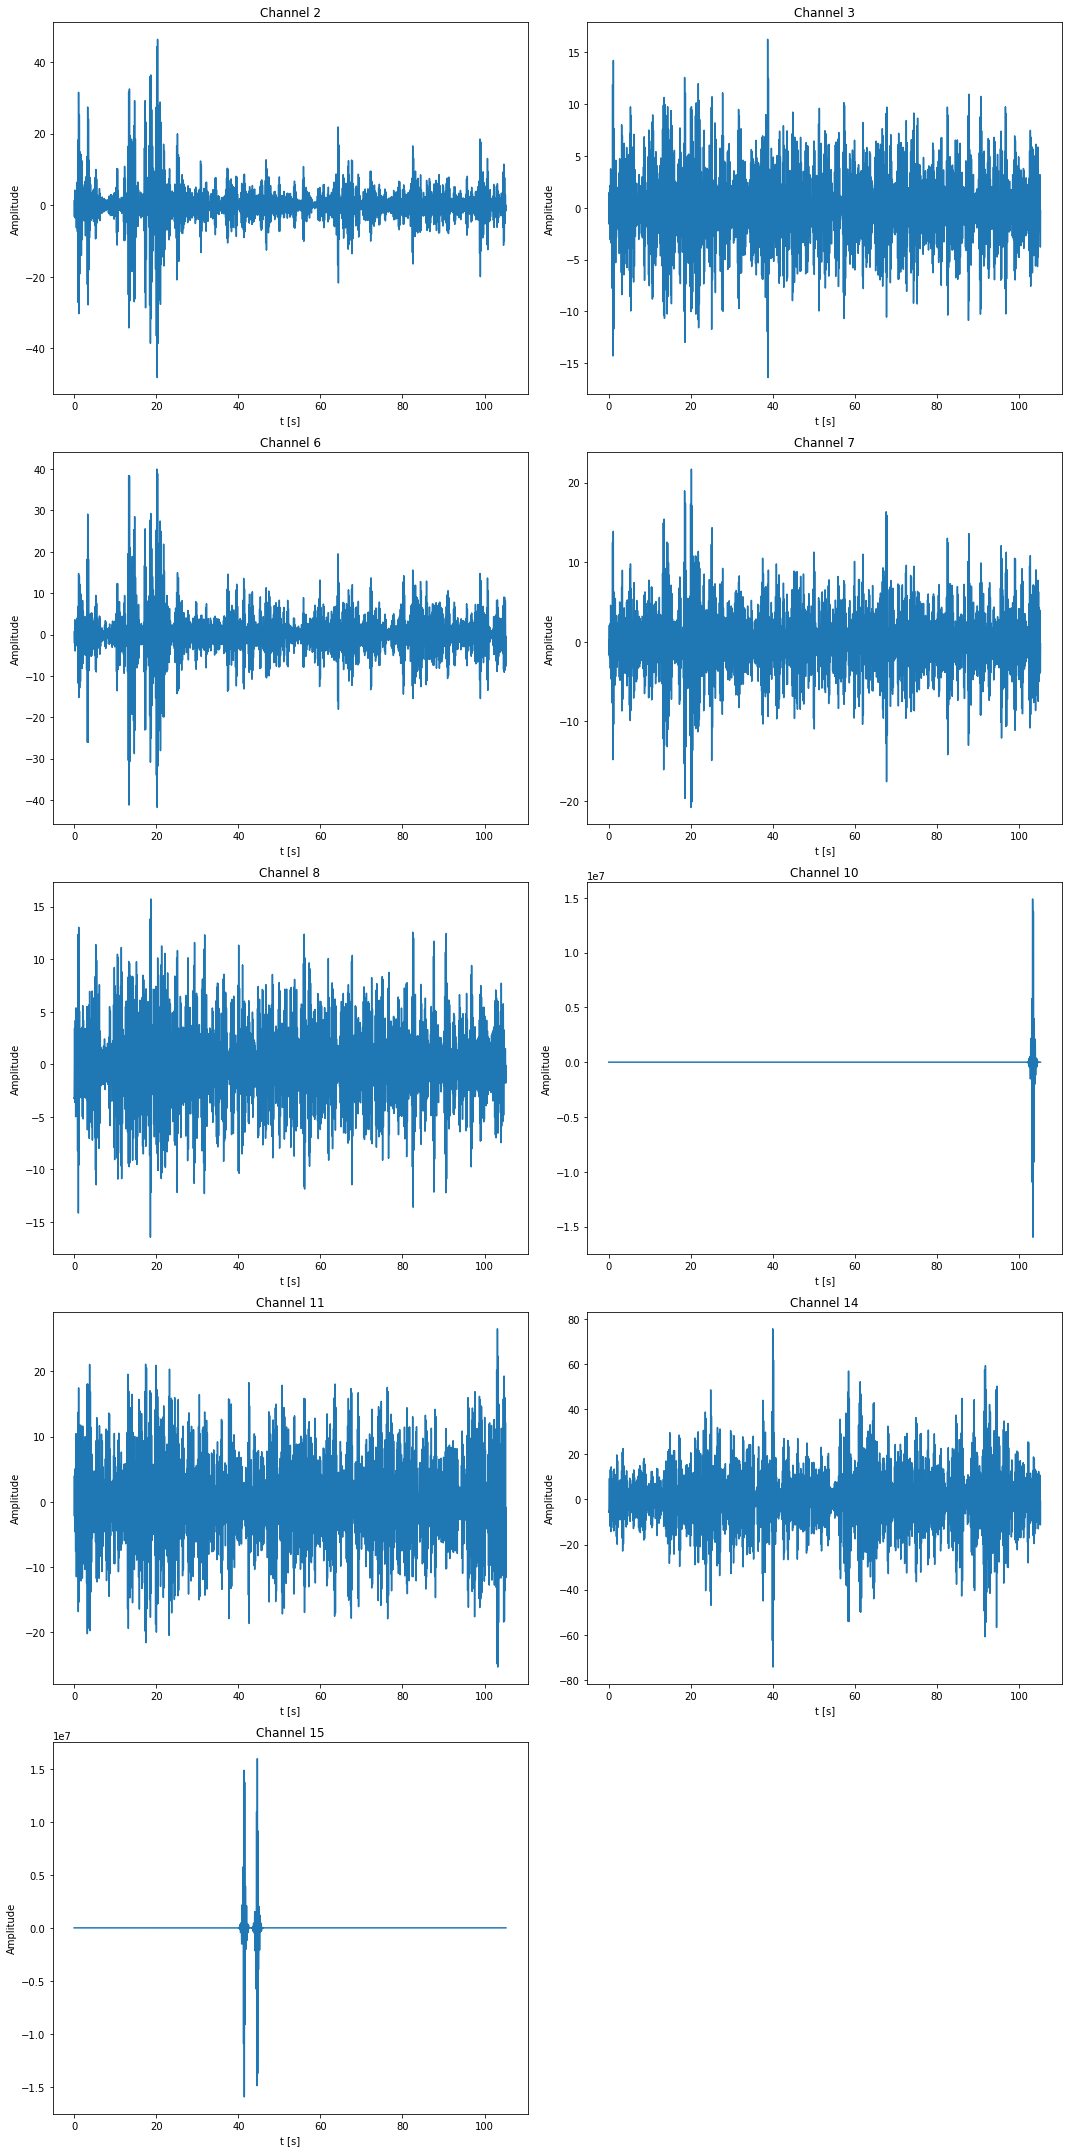

In [15]:
# Impressao dos dados:
fig, ax = plt.subplots(5, 2, figsize=(15,30))
line = 0
column = 0
for key in filtered_data:
    ax[line][column].plot(filtered_time_data, filtered_data[key])
    ax[line][column].set_title(key)
    ax[line][column].set_xlabel("t [s]")
    ax[line][column].set_ylabel("Amplitude")
    if(column == 1):
        line += 1
        column = 0
    else:
        column = 1
    
fig.delaxes(ax[4][1])
plt.tight_layout()

Análise em frequência dos dados filtrados:

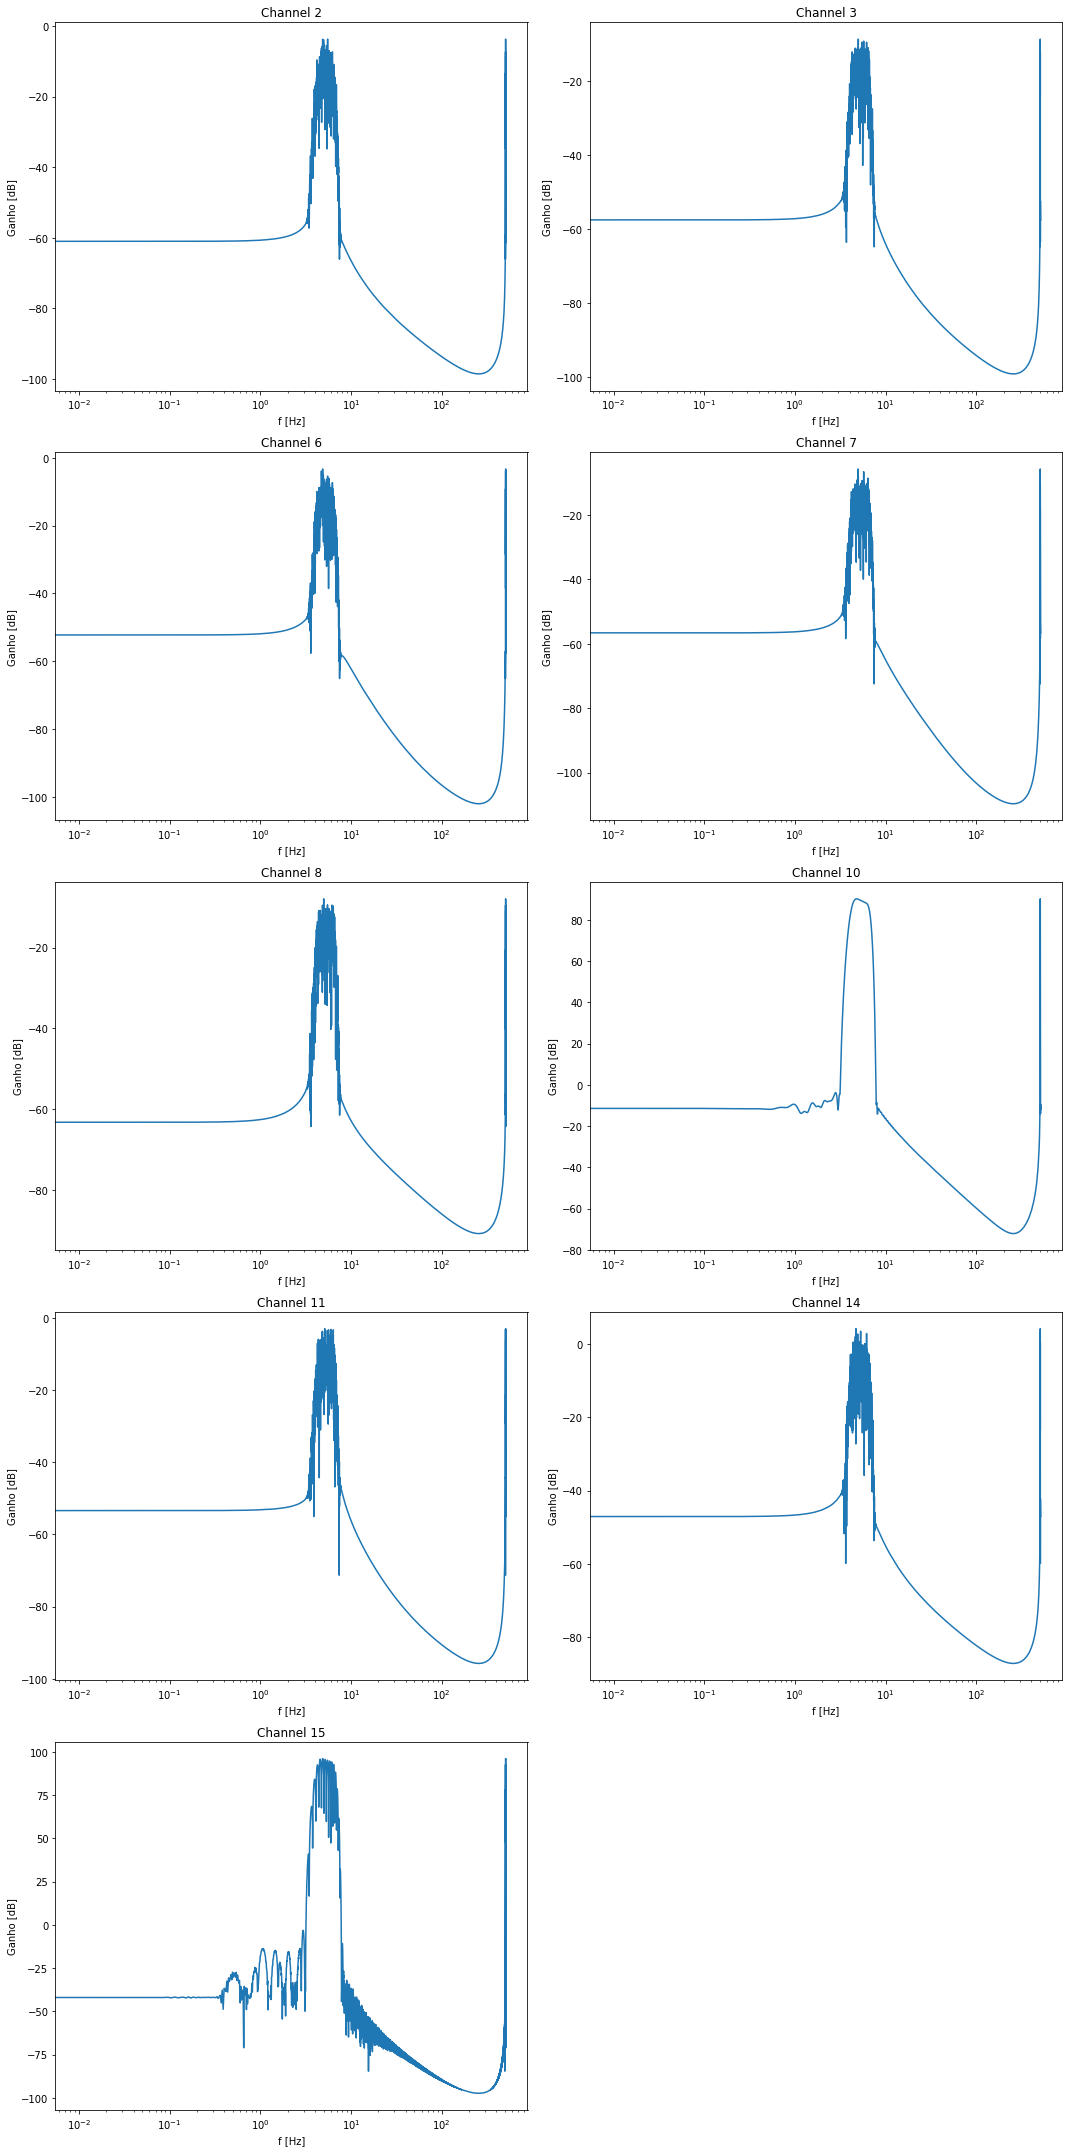

In [16]:
filtered_frq_data = pd.DataFrame()
filtered_frq_range = None # este valor sera o mesmo para todos os canais, como a taxa de amostragem e a mesma
for key in filtered_data:
    filtered_frq_range, filtered_frq_data[key] = mydft(sample_rate, filtered_data[key])
fig, ax = plt.subplots(5, 2, figsize=(15,30))
line = 0
column = 0
for key in filtered_frq_data:
    ax[line][column].semilogx(filtered_frq_range, 20*(np.log(abs(filtered_frq_data[key]))/np.log(10)))
    ax[line][column].set_title(key)
    ax[line][column].set_xlabel("f [Hz]")
    ax[line][column].set_ylabel("Ganho [dB]")
    if(column == 1):
        line += 1
        column = 0
    else:
        column = 1
    
fig.delaxes(ax[4][1])
plt.tight_layout()

Acima pode ser observado que o sinal foi bastante atenuado para frequências fora da faixa que se deseja estudar.

Agora será feito o cálculo da frequência instantânea dos dados filtrados.

In [17]:
#tmp_frq_data = dict()
#keys = []
#for key in filtered_data:
#    keys.append(key+" F")
#    tmp_frq_data[keys[-1]] = getInstantaneousFrequency(sample_rate, filtered_data[key])
# Remover ultimo ponto dos dados pois o calculo da frequencia instantanea usa uma derivada, causando a perda de um ponto.
#filtered_data = filtered_data.drop(filtered_data.index[-1])
#filtered_time_data = filtered_time_data.drop(filtered_time_data.index[-1])
#count = 1

#for key in keys:
#    filtered_data.insert(count, key, tmp_frq_data[key])
#    count+=2

#del tmp_frq_data
#del keys

#filtered_data

## Aglomeração dos dados filtrados
Agora será feita a aglomeração dos dados filtrados, para delimitar um grupo que possua os sinais das piscadas de olho.

In [18]:
from sklearn.cluster import KMeans

normalized_data = normalize(abs(filtered_data))

k = 3

my_kmeans = KMeans(n_clusters=k, max_iter=10000, n_jobs=-1)
my_kmeans.fit(normalized_data)

labels = my_kmeans.labels_

groups = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

for i in range(0, len(labels)):
    groups[labels[i]].append(i)
    
#for i in range(0, len(groups)):
    #print("Group %d:" % i)
    #print(groups[i])


In [19]:
#fig, ax = plt.subplots(9*(k+1), 1, figsize=(15,405))
#line = 0
#channels = dict()

#for key in filtered_data:
#    min_t = 0
#    max_t = 1
#    min_y = 0
#    max_y = 1
#    channel_points = []
#    if(key.endswith("F")):
#        continue
#    for group in groups:
#        if(len(group) > 0):
#            group_data = filtered_data.iloc[group]
#            local_points = (filtered_time_data[group], group_data[key])
#            channel_points.append(local_points)
#            min_t = min(min_t, min(local_points[0]))
#            max_t = max(max_t, max(local_points[0]))
#            min_y = min(min_y, min(local_points[1]))
#            max_y = max(max_y, max(local_points[1]))

#    ax[line].plot(filtered_time_data, filtered_data[key])
#    ax[line].set_xlim([min_t, max_t])
#    ax[line].set_ylim([min_y, max_y])
#    ax[line].set_title(key)
    
#    line += 1

#    for channel in channel_points:
#        ax[line].scatter(channel[0], channel[1], linewidths=1)
#        ax[line].set_xlim([min_t, max_t])
#        ax[line].set_ylim([min_y, max_y])
#        line += 1

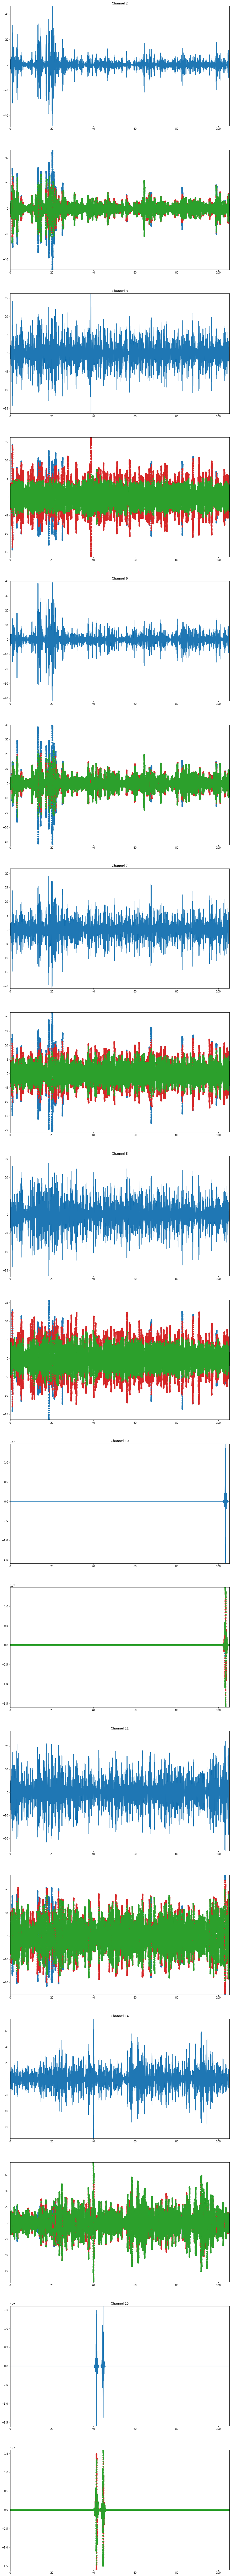

In [20]:
fig, ax = plt.subplots(9*(2), 1, figsize=(15,180))
line = 0
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:pink']

for key in filtered_data:
    min_t = 0
    max_t = 1
    min_y = 0
    max_y = 1
    channel_points = []
    if(key.endswith("F")):
        continue
    for group in groups:
        if(len(group) > 0):
            group_data = filtered_data.iloc[group]
            local_points = (filtered_time_data[group], group_data[key])
            channel_points.append(local_points)
            min_t = min(min_t, min(local_points[0]))
            max_t = max(max_t, max(local_points[0]))
            min_y = min(min_y, min(local_points[1]))
            max_y = max(max_y, max(local_points[1]))

    ax[line].plot(filtered_time_data, filtered_data[key])
    ax[line].set_xlim([min_t, max_t])
    ax[line].set_ylim([min_y, max_y])
    ax[line].set_title(key)
    
    line += 1
    i=0
    for channel in channel_points:
        ax[line].scatter(channel[0], channel[1], c=colors[i], linewidths=0.001)
        ax[line].set_xlim([min_t, max_t])
        ax[line].set_ylim([min_y, max_y])
        i+=1
    
    line += 1
        


In [21]:
group_scores = []
best_group = -1
best_score = 0
current_group = 0
for group in groups:
    local_score = 0
    for key in best_channels:
        if(len(group) > 0):
            group_data = filtered_data.iloc[group]
            local_points = abs(group_data[key])
            local_score += np.mean(local_points)
    if(local_score > best_score or best_group == -1):
        best_group = current_group
        best_score = local_score
    current_group += 1

classified_data = deepcopy(filtered_data)
classified_data["Class"] = "SIGNAL"
classified_data.loc[groups[best_group], "Class"]= "BLINK"
classified_data["Class"] = classified_data["Class"].map({"SIGNAL":1, "BLINK": 0})
classified_data

,Channel 2,Channel 3,Channel 6,Channel 7,Channel 8,Channel 10,Channel 11,Channel 14,Channel 15,Class
0,1.169507,-1.343645,0.612256,0.191397,-3.216427,-14.668383,-2.112520,-5.173154,0.498260,1
1,1.065307,-1.393401,0.605416,0.103551,-3.247816,-14.166856,-1.915666,-5.270435,0.666740,1
2,0.950708,-1.436981,0.594333,0.012904,-3.265447,-13.662597,-1.705322,-5.357957,0.836692,1
3,0.826220,-1.474163,0.578804,-0.080071,-3.269173,-13.160939,-1.482658,-5.436090,1.007174,1
4,0.692424,-1.504755,0.558650,-0.174884,-3.258908,-12.666893,-1.248918,-5.505197,1.177216,1
5,0.549962,-1.528596,0.533719,-0.271029,-3.234631,-12.185111,-1.005422,-5.565628,1.345832,1
6,0.399541,-1.545560,0.503884,-0.367984,-3.196381,-11.719861,-0.753549,-5.617717,1.512025,1
7,0.241923,-1.555550,0.469051,-0.465221,-3.144262,-11.274998,-0.494734,-5.661780,1.674790,1
8,0.077927,-1.558505,0.429153,-0.562200,-3.078443,-10.853944,-0.230458,-5.698106,1.833125,1
9,-0.091580,-1.554397,0.384160,-0.658379,-2.999152,-10.459668,0.037761,-5.726959,1.986033,1


## Validando os dados

Para validar se a clusterização obteve os resultados esperados, utilizaremos a base de dados EEG Eye State Data Set disponível no UCI, que contém dados já classificados.

In [23]:
from scipy.io import arff

data = arff.loadarff('EEG Eye State.arff')
df_UCI = pd.DataFrame(data[0])
df_UCI["eyeDetection"] = df_UCI["eyeDetection"].map({b'0':"0", b'1':1})
df_UCI["eyeDetection"] = df_UCI["eyeDetection"].astype(int)

X = classified_data.drop(["Class"], axis=1)
X = X[["Channel 2", "Channel 6"]]
y = classified_data["Class"]

X_test = df_UCI.drop(["eyeDetection"], axis=1)
X_test = X_test[["AF3", "AF4"]]

### K-Nearest Neighbors

In [24]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X, y) 

neigh.score(X_test,df_UCI["eyeDetection"])

0.5512016021361815

### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
decTree = DecisionTreeClassifier(random_state=0)
decTree.fit(X,y)

decTree.score(X_test,df_UCI["eyeDetection"])

0.5512016021361815

### SVC

In [26]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X,y)

svc.score(X_test,df_UCI["eyeDetection"])

0.5512016021361815

### Multilayer Perceptron

In [27]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier()
MLP.fit(X,y)

MLP.score(X_test,df_UCI["eyeDetection"])

0.5512683578104138

In [29]:
# Verificando as proporções do dataset
df_UCI["eyeDetection"].value_counts()

0    8257
1    6723
Name: eyeDetection, dtype: int64

Como podemos ver pelos resultados acima, todos os classificadores apresentaram um desempenho ínfimo na base de dados já classificada. Desse modo, contasta-se que a clusterização que foi realizada não conseguiu efetivamente classificar os dados.